In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/new_cbr_task

/content/drive/My Drive/new_cbr_task


In [ ]:
ls

feats_updated.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset=pd.read_csv('feats_updated.csv')


In [ ]:
dataset

,Com_ratio,Innodb_log_writes,Innodb_pages_read,Innodb_rows_inserted,Questions,Sort_scan,Workload_type
0,146.600000,22159,443681,2669835,4552,29,0
1,147.000000,22159,443681,2669835,4557,29,0
2,148.800000,22987,443714,2768641,4614,29,0
3,149.800000,22987,443715,2768641,4624,29,0
4,5.082540,36657,447667,4360025,7418,30,2
...,...,...,...,...,...,...,...
2725,117.847024,9258,340074,1019008,3013,26,1
2726,105.915639,14536,146698,646146,3349,11,1
2727,97.943126,8813,304443,248492,3624,26,1
2728,109.768157,14768,378090,1954074,3575,17,1


In [ ]:
X = dataset.iloc[:,[i for i in range(0,6)]].values
y=dataset['Workload_type'].values

In [ ]:
X.shape

(2730, 6)

In [ ]:
X.shape[0]

2730

# Data Augmentation using cGAN

The idea is to generate new and realistic fetures based on labels. GANs are excellent at generating realistic data. We can condition this generation by using [Conditional Generative Adversarial Networks](https://arxiv.org/abs/1411.1784)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
latent_dim = 200 # dimension of the latent space
n_samples = X.shape[0] # size of our dataset
n_classes = 3
n_features = X.shape[1] # we use 2 features since we'd like to visualize them

We start by creating random clusters of points, `n_classes`, with features, `n_features`. We make use of `make_blobs` from scikit learn that generates gaussian blobs

In [ ]:
#from sklearn.datasets import make_blobs

#X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=n_features, random_state=123)

print('Size of our dataset:', len(X))
print('Number of features:', X.shape[1])
print('Classes:', set(y))

Size of our dataset: 2730
Number of features: 6
Classes: {0, 1, 2}


In [ ]:
X.shape

(2730, 6)

Following we normalize our features to help with the learning

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X = scaler.fit_transform(X)

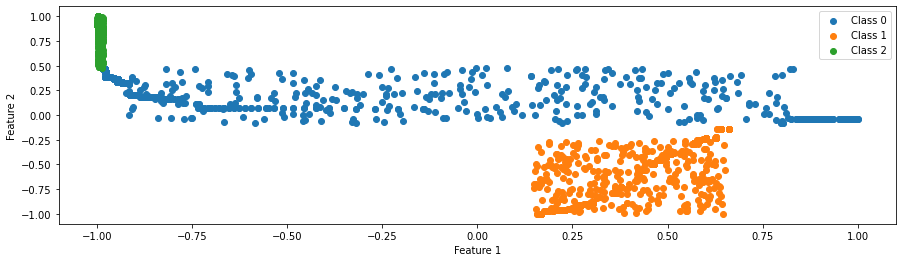

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
legend = []

for i in range(n_classes):
    plt.scatter(scaled_X[:, 0][np.where(y==i)], scaled_X[:, 1][np.where(y==i)], )
    legend.append('Class %d' % i)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(legend)

In [ ]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate, multiply

# Embedding Layers
from keras.layers import Embedding

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop, SGD

In [ ]:
def build_discriminator(optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles discriminator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    features = Input(shape=(n_features,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, n_features)(label))
    
    # We condition the discrimination of generated features 
    inputs = multiply([features, label_embedding])
    
    x = Dense(512)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    model = Model([features, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
def build_generator():
    '''
    Defines the generator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))
    
    # We condition the generation of features
    inputs = multiply([noise, label_embedding])
    
    x = Dense(256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    features = Dense(n_features, activation='tanh')(x)
    
    model = Model([noise, label], features)
    model.summary()

    return model

In [ ]:
def build_gan(generator, discriminator, optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles GAN model. It bassically chains Generator
    and Discriminator in an assembly-line sort of way where the input is
    the Generator's input. The Generator's output is the input of the Discriminator,
    which outputs the output of the whole GAN.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    
    features = generator([noise, label])
    valid = discriminator([features, label])
    
    # We freeze the discriminator's layers since we're only 
    # interested in the generator and its learning
    discriminator.trainable = False
    
    model = Model([noise, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
discriminator = build_discriminator()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 6)         18          input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 6)            0           embedding_3[0][0]                
____________________________________________________________________________________________

In [ ]:
generator = build_generator()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 200)       600         input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 200)          0           embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
gan = build_gan(generator, discriminator)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 6)            722270      input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            529427      model_5[1][0]              

In [ ]:
def get_random_batch(X, y, batch_size):
    '''
    Will return random batches of size batch_size
    
    Params:
        X: numpy array - features
        y: numpy array - classes
        batch_size: Int
    '''
    idx = np.random.randint(0, len(X))
    
    X_batch = X[idx:idx+batch_size]
    y_batch = y[idx:idx+batch_size]
    
    return X_batch, y_batch

In [ ]:
scaled_X.shape

(2730, 6)

In [ ]:
def train_gan(gan, generator, discriminator, 
              X, y, 
              n_epochs=3000, batch_size=64, 
              hist_every=10, log_every=100):
    '''
    Trains discriminator and generator (last one through the GAN) 
    separately in batches of size batch_size. The training goes as follow:
        1. Discriminator is trained with real features from our training data
        2. Discriminator is trained with fake features generated by the Generator
        3. GAN is trained, which will only change the Generator's weights.
        
    Params:
        gan: GAN model
        generator: Generator model
        discriminator: Discriminator model
        X: numpy array - features
        y: numpy array - classes
        n_epochs: Int
        batch_size: Int
        hist_every: Int - will save the training loss and accuracy every hist_every epochs
        log_every: Int - will output the loss and accuracy every log_every epochs
    
    Returns:
        loss_real_hist: List of Floats
        acc_real_hist: List of Floats
        loss_fake_hist: List of Floats
        acc_fake_hist: List of Floats
        loss_gan_hist: List of Floats
        acc_gan_hist: List of Floats
    '''
    
    half_batch = int(batch_size / 2)
    
    acc_real_hist = []
    acc_fake_hist = []
    acc_gan_hist = []
    loss_real_hist = []
    loss_fake_hist = []
    loss_gan_hist = []
    
    for epoch in range(n_epochs):
        
        X_batch, labels = get_random_batch(X, y, batch_size)
        
        # train with real values
        y_real = np.ones((X_batch.shape[0], 1))
        loss_real, acc_real = discriminator.train_on_batch([X_batch, labels], y_real)
        
        # train with fake values
        noise = np.random.uniform(0, 1, (labels.shape[0], latent_dim))
        X_fake = generator.predict([noise, labels])
        y_fake = np.zeros((X_fake.shape[0], 1))
        loss_fake, acc_fake = discriminator.train_on_batch([X_fake, labels], y_fake)
        
        y_gan = np.ones((labels.shape[0], 1))
        loss_gan, acc_gan = gan.train_on_batch([noise, labels], y_gan)
        
        if (epoch+1) % hist_every == 0:
            acc_real_hist.append(acc_real)
            acc_fake_hist.append(acc_fake)
            acc_gan_hist.append(acc_gan)
            loss_real_hist.append(loss_real)
            loss_fake_hist.append(loss_fake)
            loss_gan_hist.append(loss_gan)

        if (epoch+1) % log_every == 0:
            lr = 'loss real: {:.3f}'.format(loss_real)
            ar = 'acc real: {:.3f}'.format(acc_real)
            lf = 'loss fake: {:.3f}'.format(loss_fake)
            af = 'acc fake: {:.3f}'.format(acc_fake)
            lg = 'loss gan: {:.3f}'.format(loss_gan)
            ag = 'acc gan: {:.3f}'.format(acc_gan)

            print('{}, {} | {}, {} | {}, {}'.format(lr, ar, lf, af, lg, ag))
        
    return loss_real_hist, acc_real_hist, loss_fake_hist, acc_fake_hist, loss_gan_hist, acc_gan_hist

In [ ]:
loss_real_hist, acc_real_hist, \
loss_fake_hist, acc_fake_hist, \
loss_gan_hist, acc_gan_hist = train_gan(gan, generator, discriminator, scaled_X, y)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loss real: 0.801, acc real: 0.000 | loss fake: 0.486, acc fake: 0.969 | loss gan: 0.859, acc gan: 0.391
loss real: 0.130, acc real: 1.000 | loss fake: 0.257, acc fake: 0.906 | loss gan: 2.094, acc gan: 0.094
loss real: 0.852, acc real: 0.641 | loss fake: 0.397, acc fake: 0.891 | loss gan: 2.251, acc gan: 0.062
loss real: 0.127, acc real: 1.000 | loss fake: 0.002, acc fake: 1.000 | loss gan: 5.226, acc gan: 0.109
loss real: 0.121, acc real: 1.000 | loss fake: 0.058, acc fake: 1.000 | loss gan: 3.445, acc gan: 0.125
loss real: 0.206, acc real: 1.000 | loss fake: 0.744, acc fake: 0.641 | loss gan: 2.190, acc gan: 0.297
loss real: 0.624, acc real: 0.562 | loss fake: 0.265, acc fake: 0.844 | loss gan: 1.036, acc gan: 0.109
loss real: 0.349, acc real: 1.000 | loss fake: 0.545, acc fake: 0.781 | loss gan: 2.152, acc gan: 0.062
loss real: 0.474, acc real: 0.922 | loss fake: 0.219, acc fake: 1.000 | loss gan: 1.001, acc gan: 0.234
loss real: 0.485, acc real: 0.859 | loss fake: 0.438, acc fake: 

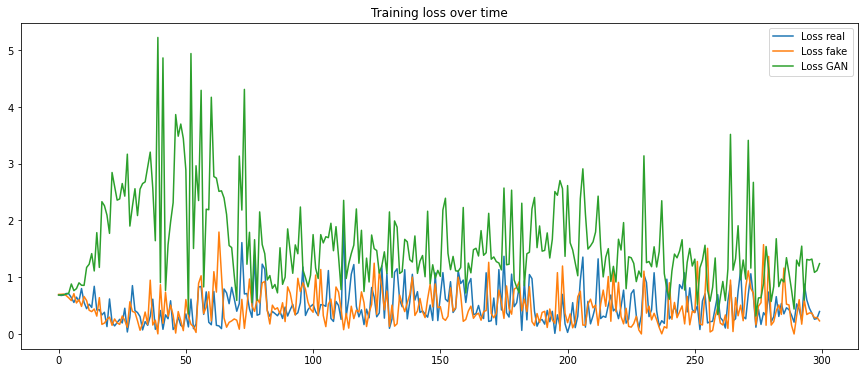

In [ ]:
ax, fig = plt.subplots(figsize=(15, 6))
plt.plot(loss_real_hist)
plt.plot(loss_fake_hist)
plt.plot(loss_gan_hist)
plt.title('Training loss over time')
plt.legend(['Loss real', 'Loss fake', 'Loss GAN'])

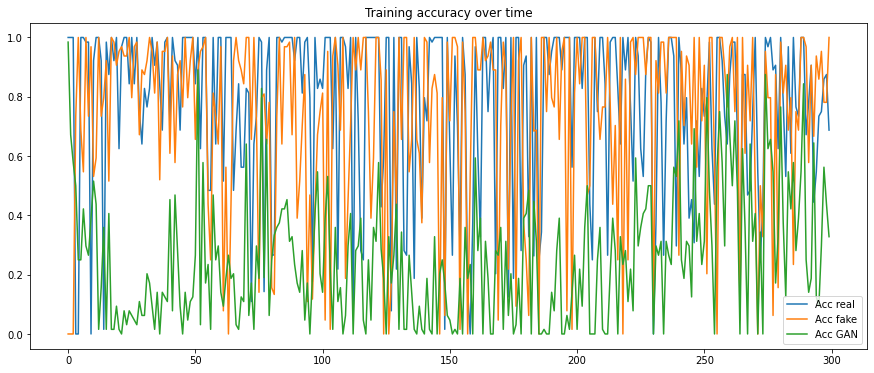

In [ ]:
ax, fig = plt.subplots(figsize=(15, 6))
plt.plot(acc_real_hist)
plt.plot(acc_fake_hist)
plt.plot(acc_gan_hist)
plt.title('Training accuracy over time')
plt.legend(['Acc real', 'Acc fake', 'Acc GAN'])

In [ ]:
def generate_samples(class_for, n_samples=400):
    '''
    Generates new random but very realistic features using
    a trained generator model
    
    Params:
        class_for: Int - features for this class
        n_samples: Int - how many samples to generate
    '''
    
    noise = np.random.uniform(0, 1, (n_samples, latent_dim))
    label = np.full((n_samples,), fill_value=class_for)
    return generator.predict([noise, label])

Let's generate new features for class 0

In [ ]:
features_class_0 = generate_samples(0)

In [ ]:
def visualize_fake_features(fake_features, figsize=(15, 6), color='r'):
    ax, fig = plt.subplots(figsize=figsize)
    
    # Let's plot our dataset to compare
    for i in range(n_classes):
        plt.scatter(scaled_X[:, 0][np.where(y==i)], scaled_X[:, 1][np.where(y==i)])

    plt.scatter(fake_features[:, 0], fake_features[:, 1], c=color)
    plt.title('Real and fake features')
    plt.legend(['Class 0', 'Class 1', 'Class 2', 'Fake'])

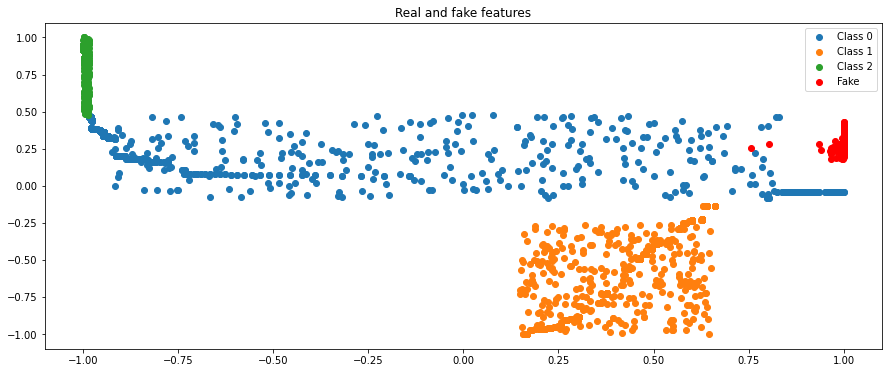

In [ ]:
visualize_fake_features(features_class_0)

New features for class 1

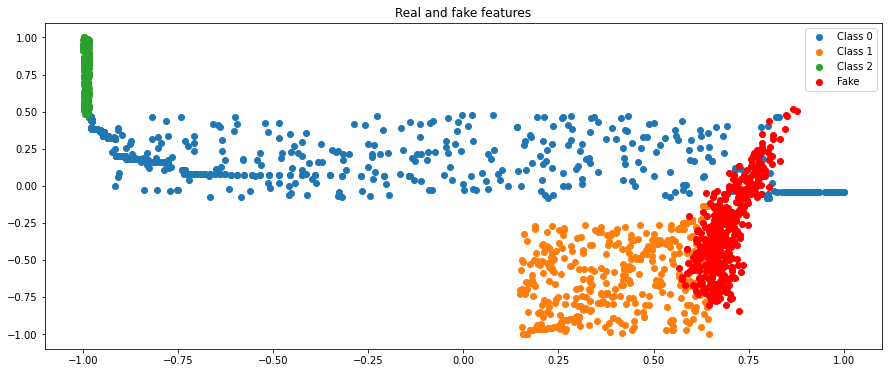

In [ ]:
features_class_1 = generate_samples(1)
visualize_fake_features(features_class_1)

New features for class 2

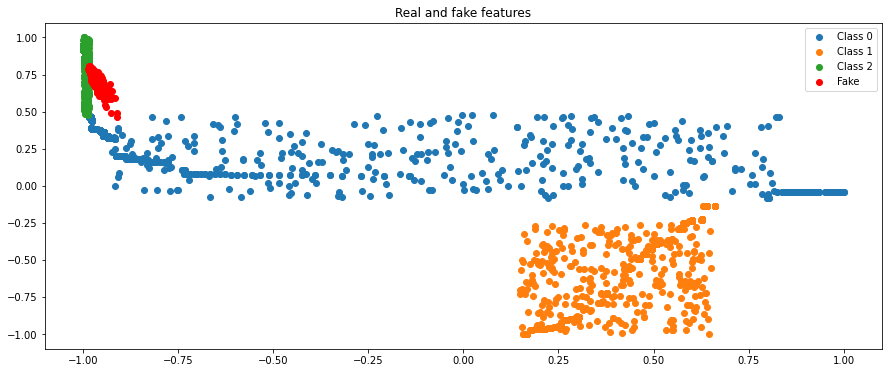

In [ ]:
features_class_2 = generate_samples(2)
visualize_fake_features(features_class_2)

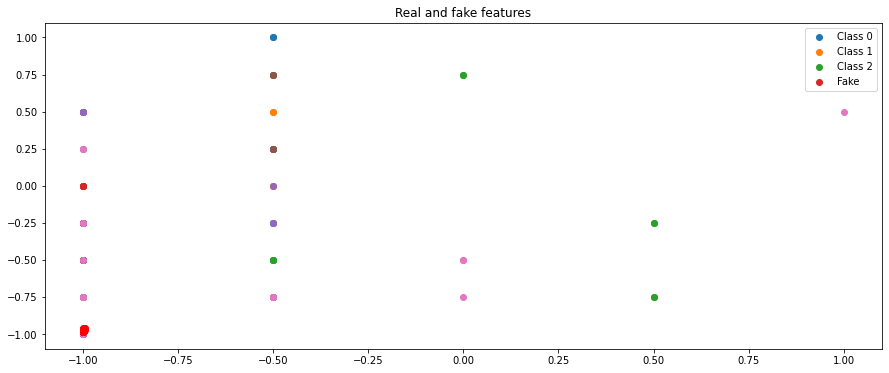

In [ ]:
features_class_3 = generate_samples(3)
visualize_fake_features(features_class_3)

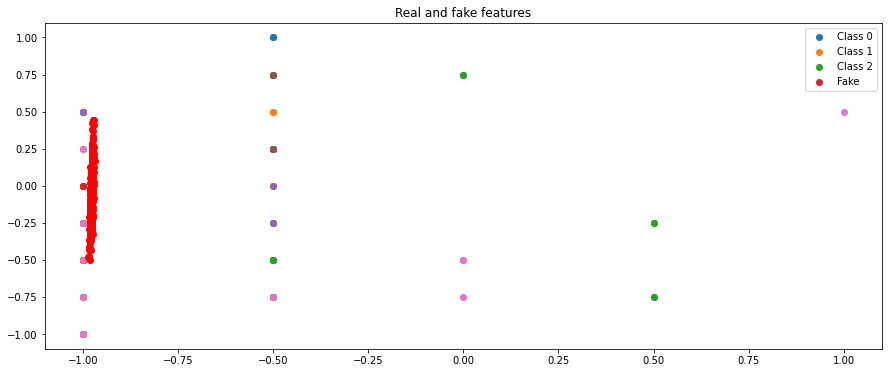

In [ ]:
features_class_4 = generate_samples(4)
visualize_fake_features(features_class_4)

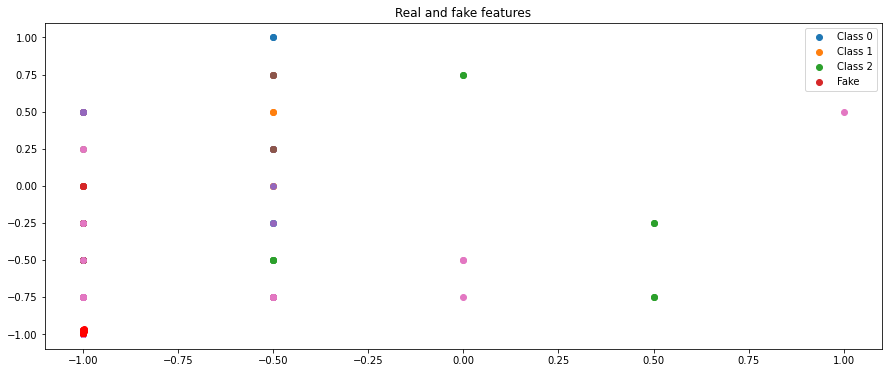

In [ ]:
features_class_5 = generate_samples(5)
visualize_fake_features(features_class_5)

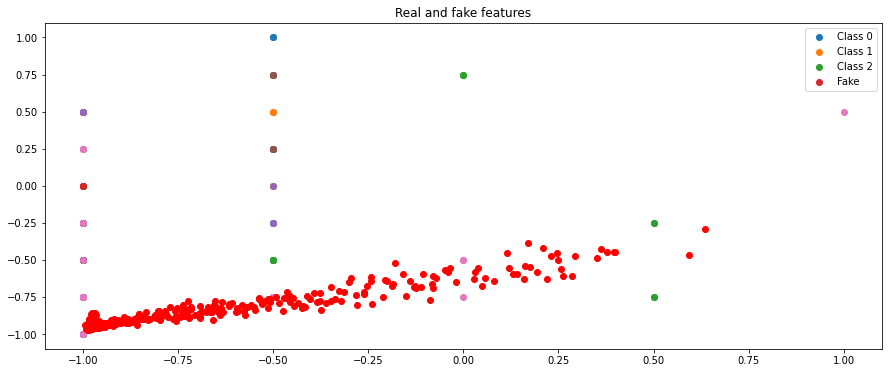

In [ ]:
features_class_6 = generate_samples(6)
visualize_fake_features(features_class_6)

In [ ]:
features_class_1 = generate_samples(1)
features_class_0 = generate_samples(0)


In [ ]:
features_class_1.shape

(400, 11)

In [ ]:
import pandas as pd 
pd.DataFrame(features_class_0).to_csv("features_class_0.csv")
pd.DataFrame(features_class_1).to_csv("features_class_1.csv")
pd.DataFrame(features_class_2).to_csv("features_class_2.csv")
#pd.DataFrame(features_class_3).to_csv("features_class_3.csv")
#pd.DataFrame(features_class_4).to_csv("features_class_4.csv")
#pd.DataFrame(features_class_5).to_csv("features_class_5.csv")
#pd.DataFrame(features_class_6).to_csv("features_class_6.csv")
#pd.DataFrame(features_class_6).to_csv("/content/drive/My Drive/Performance_prediction_tasks/data/features_class_6data8.csv")
pd.DataFrame(scaled_X).to_csv("scaled_x.csv")

In [ ]:
ls

feats_updated.csv     features_class_1.csv  scaled_x.csv
features_class_0.csv  features_class_2.csv


In [ ]:
ls

feats_updated.csv
